<a href="https://colab.research.google.com/github/BaakisanB/First/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Freelancing/Electricity_Consumption_2023-04-06_18-28-08.csv')

In [4]:
data

,billing_portion,community,rate_category,consumption_period,calendar_month,contract_account,business_partner,consumption_unit
0,912,393,COMMELEC,08.03.2023,202303,3007759777,10020574,100.0
1,B32,393,COMMELEC,15.03.2023,202303,3007749701,10045044,100.0
2,B34,591,RESIEXPE,22.03.2023,202303,3007698761,17069820,4879.0
3,B20,332,RESIEXPE,05.03.2023,202303,3007671909,10358459,33240.0
4,931,618,GOVTELEC,07.03.2023,202303,3007652891,10138030,27520.0
...,...,...,...,...,...,...,...,...
985527,B18,318,RESIEXPE,04.03.2023,202303,2000700870,10352498,603.0
985528,B18,318,COMMELEC,04.03.2023,202303,2000647715,10376569,439.0
985529,D21,127,RESIEXPE,06.03.2023,202303,2000490441,10466813,4199.0
985530,B18,318,RESIEXPE,04.03.2023,202303,2000285333,10454393,103.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985532 entries, 0 to 985531
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   billing_portion     985527 non-null  object 
 1   community           985532 non-null  int64  
 2   rate_category       985532 non-null  object 
 3   consumption_period  985532 non-null  object 
 4   calendar_month      985532 non-null  int64  
 5   contract_account    985532 non-null  int64  
 6   business_partner    985532 non-null  int64  
 7   consumption_unit    985532 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 60.2+ MB


In [6]:
data.describe()

,community,calendar_month,contract_account,business_partner,consumption_unit
count,985532.000000,985532.000000,9.855320e+05,9.855320e+05,9.855320e+05
mean,433.094738,202302.998001,2.114186e+09,1.150944e+07,2.811104e+03
std,193.919324,0.691679,2.687358e+08,1.568501e+06,2.956944e+04
min,101.000000,201806.000000,2.000000e+09,1.000000e+07,1.000000e+00
25%,318.000000,202303.000000,2.030273e+09,1.069468e+07,2.010000e+02
50%,383.000000,202303.000000,2.038613e+09,1.132511e+07,4.110000e+02
75%,621.000000,202303.000000,2.042914e+09,1.171646e+07,9.990700e+02
max,991.000000,202303.000000,3.007760e+09,2.000002e+08,8.868000e+06


In [7]:
# Convert 'consumption_period' to datetime for time series analysis
data['consumption_period'] = pd.to_datetime(data['consumption_period'], format='%d.%m.%Y')

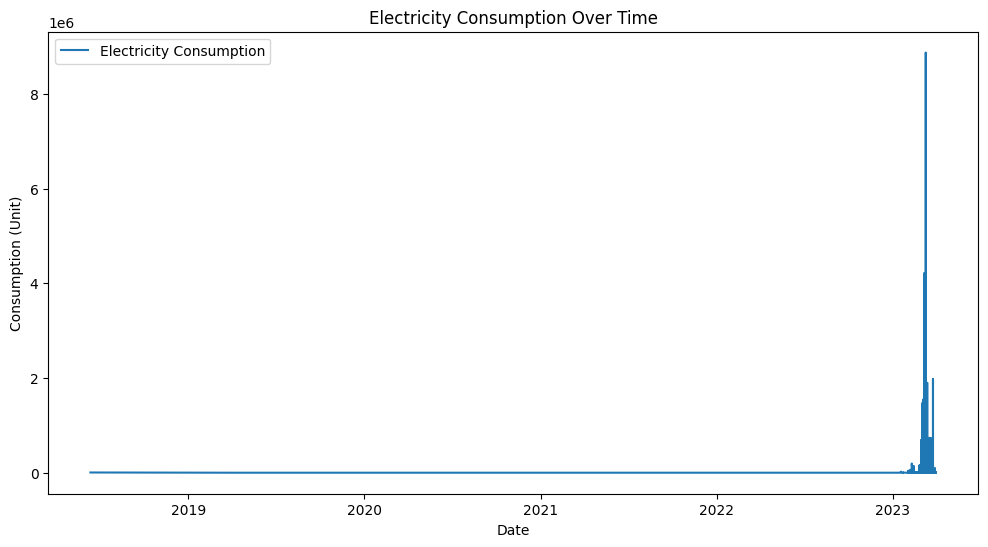

In [8]:
# Sorting the data by date
data.sort_values('consumption_period', inplace=True)

# Visualization of Electricity Consumption over Time
plt.figure(figsize=(12, 6))
plt.plot(data['consumption_period'], data['consumption_unit'], label='Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (Unit)')
plt.title('Electricity Consumption Over Time')
plt.legend()
plt.show()

In [9]:
# # Distribution of Electricity Consumption
# plt.figure(figsize=(8, 6))
# sns.histplot(data['consumption_unit'], kde=False)
# plt.title('Distribution of Electricity Consumption')
# plt.xlabel('Consumption (Unit)')
# plt.ylabel('Frequency')
# plt.show()

In [10]:
data1 = data.drop('calendar_month', axis = 1)

In [11]:
data.head()

,billing_portion,community,rate_category,consumption_period,calendar_month,contract_account,business_partner,consumption_unit
26043,D31,900,RESIEXPE,2018-06-12,201806,2011782570,10482939,5020.0
3297,D33,621,RESIEXPE,2019-04-09,201904,3003722007,10011294,100.0
3378,D31,631,RESIEXPE,2021-04-18,202104,3003531511,17074602,100.0
17421,B22,333,RESIEXPE,2022-11-15,202211,2035148537,10896429,100.0
3906,B34,598,COMMELEC,2022-12-21,202212,3002655095,10023772,100.0


In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError

# Drop rows with missing values
data = data1.dropna()

# Encode categorical columns
label_encoders = {}
for column in ['billing_portion', 'rate_category', 'consumption_period']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data

,billing_portion,community,rate_category,consumption_period,contract_account,business_partner,consumption_unit
26043,33,900,6,0,2011782570,10482939,5020.0
3297,34,621,6,1,3003722007,10011294,100.0
3378,33,631,6,2,3003531511,17074602,100.0
17421,16,333,6,3,2035148537,10896429,100.0
3906,22,598,0,4,3002655095,10023772,100.0
...,...,...,...,...,...,...,...
16694,22,685,6,82,2035738431,11522018,100.0
38630,29,231,6,82,2041381701,11588277,751.0
38778,20,392,6,82,2041324422,11766604,126.0
38071,18,353,6,82,2041739835,11786890,249.0


In [13]:
# Extract features and target variable
X = data.drop(columns=['consumption_unit'])  # Features
y = data['consumption_unit']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create the LSTM neural network
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))

# Compile the model with Mean Absolute Error as a metric
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[MeanAbsoluteError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69120     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69249 (270.50 KB)
Trainable params: 69249 (270.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=2)

# Evaluate the model's performance
loss, mae = model.evaluate(X_test_reshaped, y_test, verbose=0)

print("Mean Squared Error:", loss)
print("Mean Absolute Error:", mae)


Epoch 1/100
24639/24639 - 131s - loss: 962527168.0000 - mean_absolute_error: 3208.8118 - 131s/epoch - 5ms/step
Epoch 2/100
24639/24639 - 141s - loss: 946714624.0000 - mean_absolute_error: 3659.3679 - 141s/epoch - 6ms/step
Epoch 3/100
24639/24639 - 131s - loss: 940364608.0000 - mean_absolute_error: 3611.0842 - 131s/epoch - 5ms/step
Epoch 4/100
24639/24639 - 128s - loss: 936771776.0000 - mean_absolute_error: 3513.6960 - 128s/epoch - 5ms/step
Epoch 5/100
24639/24639 - 129s - loss: 934402560.0000 - mean_absolute_error: 3467.5405 - 129s/epoch - 5ms/step
Epoch 6/100
24639/24639 - 131s - loss: 932450112.0000 - mean_absolute_error: 3424.8425 - 131s/epoch - 5ms/step
Epoch 7/100
24639/24639 - 127s - loss: 930810240.0000 - mean_absolute_error: 3401.7402 - 127s/epoch - 5ms/step
Epoch 8/100
24639/24639 - 128s - loss: 929219264.0000 - mean_absolute_error: 3405.6323 - 128s/epoch - 5ms/step
Epoch 9/100
24639/24639 - 127s - loss: 927828608.0000 - mean_absolute_error: 3378.9583 - 127s/epoch - 5ms/step
E

In [ ]:
! pip install prophet

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from prophet import Prophet

# Drop rows with missing values
data = data1.dropna()

# Convert 'consumption_period' to datetime
data['consumption_period'] = pd.to_datetime(data['consumption_period'])

# Rename columns for Prophet
data.rename(columns={'consumption_period': 'ds', 'consumption_unit': 'y'}, inplace=True)

# Extract features and target variable
X = data.drop(columns=['y'])  # Features
y = data['y']  # Target variable

# Sort data chronologically
data = data.sort_values('ds')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the training data for Prophet
train_data = pd.concat([X_train, y_train], axis=1)

# Create the Prophet model
model = Prophet()

In [ ]:
model.fit(train_data)

# Make predictions for the test set
future = model.make_future_dataframe(periods=1000)
forecast = model.predict(future)

# Extract predicted values for the test set
predictions = forecast['yhat'][len(train_data):]

# Evaluate the model's performance
mse = np.mean((predictions - y_test.values)**2)
mae = np.mean(np.abs(predictions - y_test.values))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

In [ ]:
# # Check the data for missing values or gaps
# data = data.dropna()

# # Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]
# data = data.drop(outliers.index)

# # Scale the data
# data = data / data.max()

In [ ]:
# # Split the data into training and test sets
# train_data = data[:int(0.8 * len(data))]
# test_data = data[int(0.8 * len(data)):]

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# # Identify the trend and seasonal components of the data set
# trend = seasonal_decomp(data["y"], freq=7).trend
# seasonal = seasonal_decomp(data["y"], freq=7).seasonal
# residual = data["y"] - trend - seasonal

# # Calculate the properties of the ARIMA model
# p = 1
# d = 1
# q = 1

# # Create the ARIMA model
# model = ARIMA(residual, order=(p, d, q))

In [ ]:
# # Train the model using the training data set
# model.fit()

In [ ]:
# # Make predictions on the test data set
# predictions = model.predict(start=len(train_data), end=len(data))

# # Compare the predictions to the actual values and calculate the accuracy
# accuracy = np.mean(predictions == test_data["y"])

In [ ]:
# # Split the data into training and test sets
# train_data = data[:int(0.8 * len(data))]
# test_data = data[int(0.8 * len(data)):]

# # Create the LSTM neural network
# model = Sequential()
# model.add(LSTM(128, activation="relu", input_shape=(train_data.shape[1],)))
# model.add(Dense(1))

# # Train the model with the MSE loss function
# model.compile(loss="mse", optimizer="adam")
# model.fit(train_data, train_data[:, 0], epochs=100)

# # Evaluate the model's performance
# predictions = model.predict(test_data)

# # Calculate the MSE loss
# mse = np.mean((predictions - test_data[:, 0])**2)

# print("MSE loss:", mse)

In [ ]:
# # Create the Prophet model
# model = Prophet()
# model.fit(data)

# # Train the model with the MSE loss function
# model.fit(data, loss="mse")

# # Evaluate the model's performance
# future = model.make_future_dataframe(periods=100)
# forecast = model.predict(future)

# # Calculate the MSE loss
# mse = np.mean((forecast["yhat"] - data["y"])**2)

# print("MSE loss:", mse)

In [ ]:
# # Check the data for missing values or gaps
# data = data.dropna()

# # Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]
# data = data.drop(outliers.index)

# # Scale the data
# data = data / data.max()

In [ ]:
# Check the data for missing values or gaps
# data = data.dropna()

# Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]

# Determine the cause of the outliers
# for outlier in outliers:
#     print(outlier, data[outlier])

In [ ]:
# # Replace outliers with the mean
# for outlier in outliers:
#     data[outlier] = data.mean()

In [ ]:
# # Delete outliers
# data = data.drop(outliers.index)